- Initially you will see grayscale images
- Yellow shades and blue shades will be learned first.
- Red shade is learned eventually.
- Green shade is learned very late. Takes about 5 epochs.

## Download and Prepare Dataset

COCO Dataset - Terms of use: http://cocodataset.org/#termsofuse

Skip these cells if COCO dataset is already downloaded.

In [0]:
# Download Dataset
#!wget http://images.cocodataset.org/zips/train2017.zip
!wget https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip

--2019-09-20 18:06:10--  https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/d1kjpkqklf0uw77/celeba.zip [following]
--2019-09-20 18:06:11--  https://www.dropbox.com/s/raw/d1kjpkqklf0uw77/celeba.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1145b3efeef817234b1427b1d1.dl.dropboxusercontent.com/cd/0/inline/Ao6bbeCyuQ8XKMK_BmEWxEq9-698agh1f483ztqeXnZ8H5Mdq-g8rGr5VUPRVxVR1d2gEuMvYQTVWf-MTqn0QGSZX4mIaDZop8SriWaaS2Ay3g/file# [following]
--2019-09-20 18:06:11--  https://uc1145b3efeef817234b1427b1d1.dl.dropboxusercontent.com/cd/0/inline/Ao6bbeCyuQ8XKMK_BmEWxEq9-698agh1f483ztqeXnZ8H5Mdq-g8rGr5VUPRVxVR1d2gEuMvYQTVWf-MTqn0QGSZX4mIaDZop8SriWaaS2Ay3g/file
Resolving uc1145b3efee

In [0]:
# Extract Dataset
#!mkdir data
#!unzip train2017.zip -d ./data >> /dev/null
!unzip celeba.zip -d ./data >> /dev/null

## Code

In [0]:

from matplotlib import pyplot as plt
import numpy as np

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as dset
from torchvision.utils import save_image
import torchvision.utils as vutils
from torchsummary import summary
from IPython import display
from PIL import Image

%matplotlib inline

In [0]:
# Configurations
dataroot = "./data"

image_size = 256
nb_channls=3
workers=4
num_epochs = 10
batch_size = 4
learning_rate = 1e-3
weight_decay = 1e-5

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), nb_channls, image_size, image_size)
    return x

device

device(type='cuda', index=0)

In [0]:
# Load Dataset
'''
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((image_size//4, image_size//4)),
                               transforms.ToTensor(),
                           ]),
                           target_transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                           ]))
                           '''
from torch.utils.data import Dataset
from torchvision.datasets.folder import ImageFolder
from PIL import Image

import os
import os.path
import sys

class MyDataset(ImageFolder):
    def __init__(self, root, input_transform=None, output_transform=None):
        super(MyDataset, self).__init__(root, transform=input_transform)
        self.input_transform = input_transform
        self.output_transform = output_transform
        
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        
        if self.transform:
            img1 = self.input_transform(img)
            img2 = self.output_transform(img)
            
        return img1, img2


dataset = MyDataset(dataroot,
                    input_transform=transforms.Compose([
                        transforms.Resize((image_size//4, image_size//4)),
                        transforms.ToTensor(),
                    ]),
                    output_transform=transforms.Compose([
                        transforms.Resize((image_size, image_size)),
                        transforms.ToTensor(),
                    ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [0]:
import math

import torch.nn.functional as F
from torch import nn


import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

import numpy as np
class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x

class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)



    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk
        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))
        output = out.data
        output = output.float().cpu().clamp_(0, 1)
        return output



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


In [0]:
#from google.colab import files
#uploaded = files.upload()


In [0]:
import torch
from torch import nn
from torchvision.models.vgg import vgg16


class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:30]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()
        

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]




In [0]:
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm


netG = RRDBNet(3, 3, 64, 23, gc=32)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
state_dict = torch.load('./RRDB_ESRGAN_x4.pth')
netG.load_state_dict(state_dict)
netG.itr = 0
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

generator_criterion = GeneratorLoss()

if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

netG.train()
netD.train()


# generator parameters: 16697987
# discriminator parameters: 5215425


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, 

iter [0], loss:0.002161 0.999650061


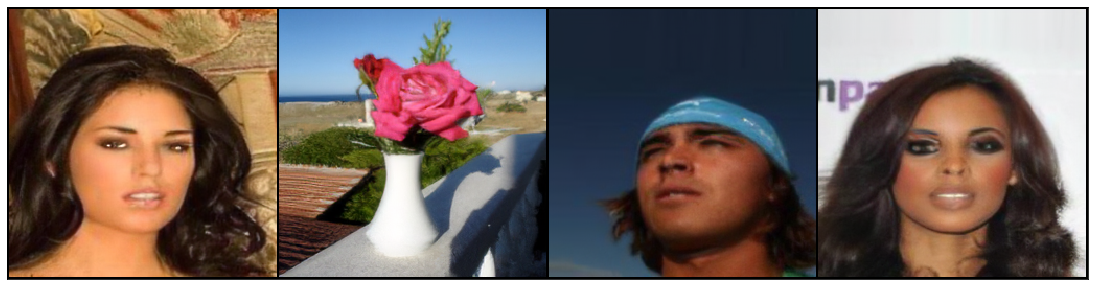

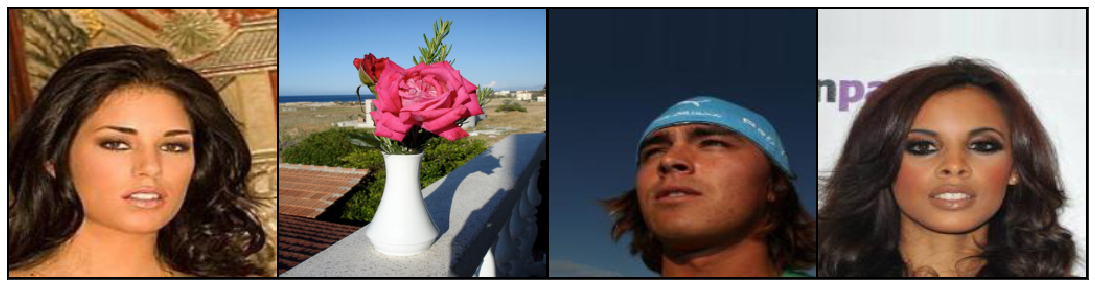

iter [50], loss:0.002259 0.994364500


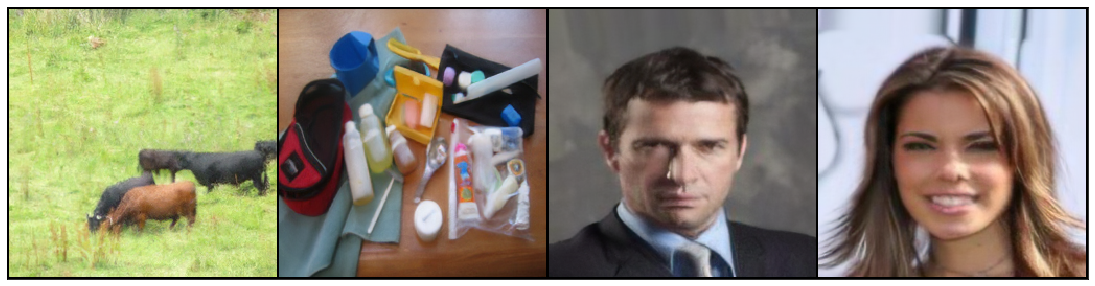

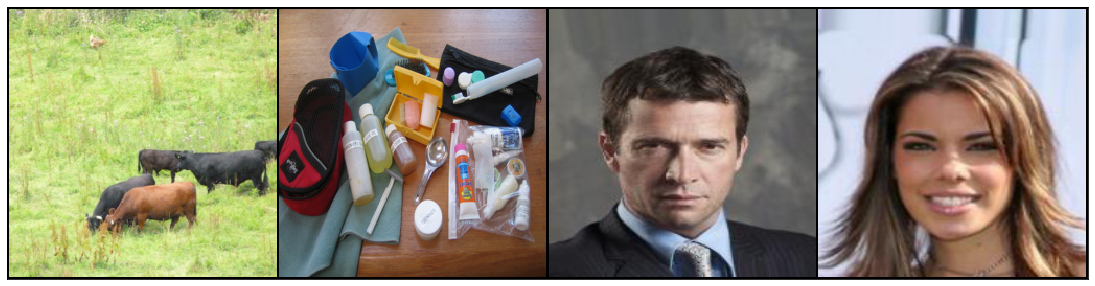

iter [100], loss:0.002152 1.019855499


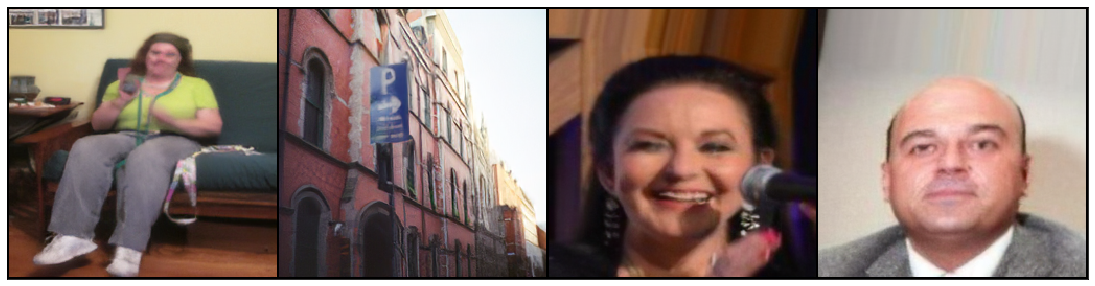

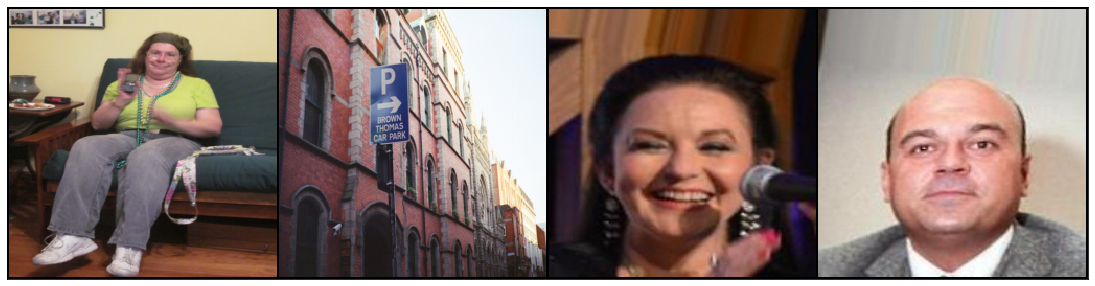

iter [150], loss:0.004200 1.000905514


In [0]:
# Training Loop. Results will appear every 50th iteration.
for epoch in range(num_epochs):
    for data, target in dataloader:
        g_update_first = True
        batch_size = data.size(0)

        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z).to(device)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_ = d_loss.data.item()
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        netG.zero_grad()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_ = g_loss.data.item()
        g_loss.backward()
        optimizerG.step()
        
        if netG.itr % 50 == 0:
            # Log
            print('iter [{}], loss:{:f} {:.9f}'
              .format(netG.itr, g_, d_))
            pic = to_img(fake_img.to("cpu").data)
            orig = to_img(real_img.to("cpu").data)
        
          
            fig = plt.figure(  figsize=(20, 5),)
            btch = pic.to(device)[:4]
            ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2, normalize=True).cpu(),(1,2,0)))
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            plt.show(fig)
            fig = plt.figure(  figsize=(20, 5),)
            btch = orig.to(device)[:4]
            ax = plt.imshow(np.transpose(vutils.make_grid(btch, padding=2, normalize=True).cpu(),(1,2,0)))
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            plt.show(fig)
        
        if netG.itr % 500 == 0:
          torch.save(netG.state_dict(), './srgan_'+str(netG.itr)+'.pth')
          #import time
          #time.sleep(20)
          #from google.colab import files
          #files.download('./superres_'+str(itr)+'.pth')
            
        netG.itr += 1

    print('epoch [{}/{}], loss:{:f}'
          .format(epoch + 1, num_epochs, loss.data.item()))

In [0]:


# Preview Results
for data in dataloader:
  img, _ = data        
  img = Variable(img).to(device)
  output = model(img)
  break

In [0]:
# Preview before compression
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(img.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# Preview after compression
pic = to_img(output.to("cpu").data)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(pic.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
!cp data/val2017/00000055* data_/

In [0]:
!ls 

In [0]:
!zip -r data_.zip data_/

In [0]:
# Download Weights
from google.colab import files
files.download('data_.zip')


In [0]:
print(encoder_model.state_dict())